In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import re
import json
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from scipy.stats import zscore
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# For google colab and drive only
drive.mount('/content/drive')

Mounted at /content/drive


Load Data:

In [ ]:
# Init df (please change the file path to your own path that store the csv files for all the following codes)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/query_exec_times.csv')
# Clean the query format
df['SQL_query'] = df['SQL_query'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))
df.head()

,query_id,SQL_query,execution time (ms),if_indexed,trial
0,1,"select l_returnflag, l_linestatus, sum(l_quant...",38804.309,1,1
1,2,"select s_acctbal, s_name, n_name, p_partkey, p...",207850.800,1,1
2,3,"select l_orderkey, sum(l_extendedprice*(1-l_di...",29576.759,1,1
3,4,"select o_orderpriority, count(*) as order_coun...",19785.697,1,1
4,5,"select n_name, sum(l_extendedprice * (1 - l_di...",156007.239,1,1


In [ ]:
# stats of our target variables
df['execution time (ms)'].describe()

,execution time (ms)
count,7.500000e+02
mean,3.837686e+04
std,6.702968e+04
min,4.483330e+02
25%,9.869873e+03
50%,2.487113e+04
75%,3.796432e+04
max,1.020492e+06


In [ ]:
# Load model for embeddings (here we use the sentence transformer)
model = SentenceTransformer("s2593817/sft-sql-embedding")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/208 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

In [ ]:
# apply embeddings (might be slow without gpu)
df['query_embedding'] = df['SQL_query'].apply(lambda x: model.encode(x))
df.to_csv('/content/drive/My Drive/Colab Notebooks/embeddings.csv', index=False)
print("embeddings has been downloaded to your Google Drive.")
df.head()

In [ ]:
# Load the pre-trained embeddings from the saved CSV file if previously done embeddings
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/embeddings.csv',
                 dtype = {'query_id': str,
                          'SQL_query': str,
                          'execution time (ms)': float,
                          'if_indexed': bool,
                          'query_embedding': str})
df['query_embedding'] = df['query_embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
df.head()

,query_id,SQL_query,execution time (ms),if_indexed,trial,query_embedding
0,1,"select l_returnflag, l_linestatus, sum(l_quant...",38804.309,True,1,"[-0.02308319, -0.02952782, 0.02626665, -0.0152..."
1,2,"select s_acctbal, s_name, n_name, p_partkey, p...",207850.800,True,1,"[-0.0162052289, -0.0373648293, 0.0290722232, -..."
2,3,"select l_orderkey, sum(l_extendedprice*(1-l_di...",29576.759,True,1,"[-0.018719703, -0.0425800495, 0.0271069985, -0..."
3,4,"select o_orderpriority, count(*) as order_coun...",19785.697,True,1,"[-0.0182057787, -0.0372952335, 0.0211798865, -..."
4,5,"select n_name, sum(l_extendedprice * (1 - l_di...",156007.239,True,1,"[-0.0168541614, -0.0323751681, 0.0244212672, -..."


# Baseline Model
We implemented a baseline linear regression model to predict SQL query execution time in milliseconds. The input feature matrix combines the query embeddings (768-dimensional vectors) with an additional binary feature indicating whether an index is used for the query. The target variable is the actual execution time.

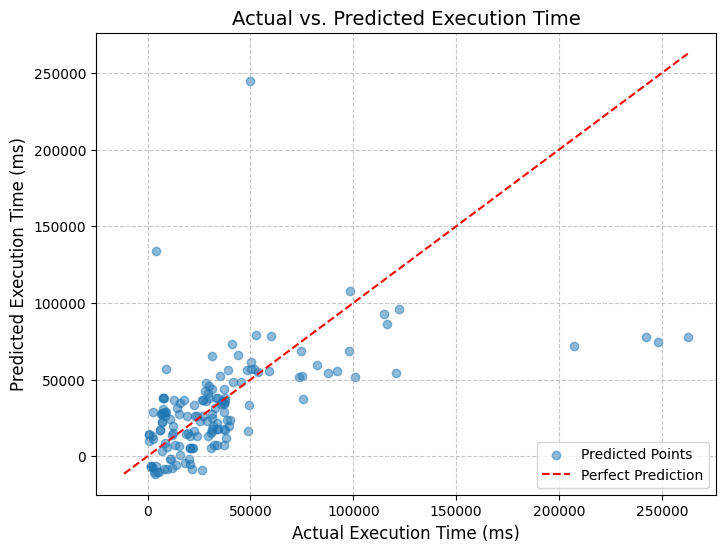

In [ ]:
# Prepare the feature matrix X and target vector y
index_feature = df['if_indexed'].to_numpy().reshape(-1, 1)
X = np.hstack((np.vstack(df['query_embedding'].to_numpy()), index_feature))
y = df['execution time (ms)'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted Points")
plt.xlabel("Actual Execution Time (ms)", fontsize=12)
plt.ylabel("Predicted Execution Time (ms)", fontsize=12)
plt.title("Actual vs. Predicted Execution Time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()

plt.show()

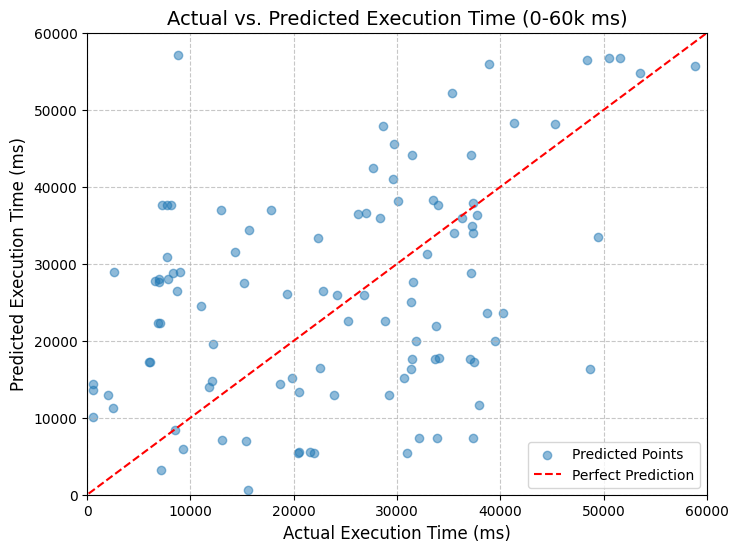

In [ ]:
# Look at the range of 0-60k ms
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted Points")
plt.xlabel("Actual Execution Time (ms)", fontsize=12)
plt.ylabel("Predicted Execution Time (ms)", fontsize=12)
plt.title("Actual vs. Predicted Execution Time (0-60k ms)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()

plt.xlim(0,60000)
plt.ylim(0,60000)

plt.show()

In [ ]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Original Scale")
print(f"R-squared (R2) Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Original Scale
R-squared (R2) Score: 0.20904694095200105
Mean Squared Error (MSE): 1438410984.4872067
Root Mean Squared Error (RMSE): 37926.389025152486


In [ ]:
# Save the model
joblib.dump(model, '/content/drive/My Drive/models/baseline_linear_regression')

['/content/drive/My Drive/models/baseline_linear_regression']

# RNN
We designed an RNN model to predict SQL query execution time by leveraging the sequential nature of query embeddings. The model takes as input 768-dimensional query embeddings generated from a pre-trained sentence transformer, combined with a binary feature indicating whether an index was used. The architecture consists of a single-layer RNN with 128 hidden units (due to the small dataset). This processes the embeddings sequentially to capture temporal dependencies and structural patterns within the SQL queries. A fully connected layer maps the final hidden state to a single output for the predicted execution time. We trained the model using Mean Squared Error (MSE) as the loss function and carefully tuned hyperparameters such as the learning rate and hidden size to achieve a balance between model complexity and training stability.

In [127]:
# Prepare the feature matrix (embeddings + index feature) and target
X = np.vstack(df['query_embedding'].to_numpy())
index_feature = df['if_indexed'].values.reshape(-1, 1)
y = df['execution time (ms)'].values
# Normalize y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Combine embeddings and index feature
X_combined = np.hstack((X, index_feature))


X_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [128]:
class RNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc_final = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)  # 2 for bidirectional
        out, _ = self.rnn(x.unsqueeze(1), h0)  # unsqueeze to add batch dimension
        rnn_output = out[:, -1, :]  # Take the last output
        out = self.fc_final(rnn_output)
        return out

In [129]:
# Model configuration
input_size = X_combined.shape[1]
hidden_size = 128
num_layers = 1
learning_rate = 0.01

model = RNNPredictor(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

# Training loop with model checkpointing for best weights
num_epochs = 50
best_test_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation on test data (acting as validation)
    model.eval()
    test_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            y_pred_ori = scaler.inverse_transform(outputs.numpy())
            y_actual_ori = scaler.inverse_transform(y_batch.numpy())
            predictions.extend(y_pred_ori)
            actuals.extend(y_actual_ori)

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Test MSE Loss: {avg_test_loss:.4f}')

    # Save best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_test_loss_ori = np.mean((np.array(predictions) - np.array(actuals)) ** 2)
        best_model_state = model.state_dict()

# Load best model weights for future use
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    torch.save(best_model_state, f"/content/drive/My Drive/models/{np.sqrt(best_test_loss_ori):.2f}_RNN_best_model.pth")
    print("Best model state saved to 'best_model.pth'")
    print(f"Loaded best model with Test MSE Loss in original scale: {best_test_loss_ori:.4f}")
    print(f"Loaded best model with Test RMSE Loss in original scale: {np.sqrt(best_test_loss_ori):.4f}")


Epoch [1/50], Training Loss: 1.2702, Test MSE Loss: 0.2759
Epoch [2/50], Training Loss: 1.2187, Test MSE Loss: 1.1344
Epoch [3/50], Training Loss: 1.3149, Test MSE Loss: 0.3751
Epoch [4/50], Training Loss: 1.0688, Test MSE Loss: 0.4064
Epoch [5/50], Training Loss: 1.1754, Test MSE Loss: 0.2041
Epoch [6/50], Training Loss: 1.1661, Test MSE Loss: 0.2787
Epoch [7/50], Training Loss: 0.9815, Test MSE Loss: 2.2132
Epoch [8/50], Training Loss: 1.1285, Test MSE Loss: 0.2163
Epoch [9/50], Training Loss: 0.9098, Test MSE Loss: 0.1680
Epoch [10/50], Training Loss: 0.9272, Test MSE Loss: 0.5483
Epoch [11/50], Training Loss: 1.0304, Test MSE Loss: 0.1378
Epoch [12/50], Training Loss: 0.8861, Test MSE Loss: 0.2368
Epoch [13/50], Training Loss: 0.8983, Test MSE Loss: 0.2443
Epoch [14/50], Training Loss: 1.0805, Test MSE Loss: 0.2090
Epoch [15/50], Training Loss: 1.0099, Test MSE Loss: 0.1356
Epoch [16/50], Training Loss: 0.9637, Test MSE Loss: 0.1192
Epoch [17/50], Training Loss: 1.0911, Test MSE Lo

In [135]:
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        y_pred_ori = scaler.inverse_transform(outputs.numpy())
        y_actual_ori = scaler.inverse_transform(y_batch.numpy())
        predictions.extend(y_pred_ori)
        actuals.extend(y_actual_ori)

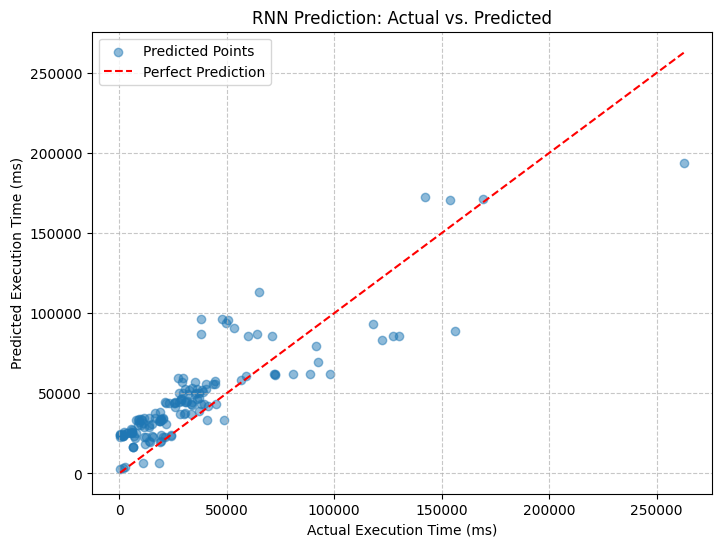

In [136]:
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5, label="Predicted Points")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Execution Time (ms)")
plt.ylabel("Predicted Execution Time (ms)")
plt.title("RNN Prediction: Actual vs. Predicted")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

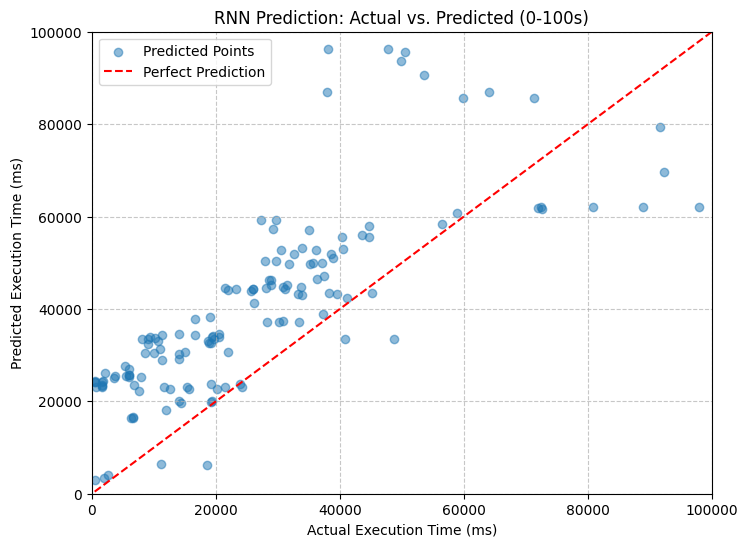

In [137]:
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5, label="Predicted Points")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Execution Time (ms)")
plt.ylabel("Predicted Execution Time (ms)")
plt.title("RNN Prediction: Actual vs. Predicted (0-100s)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0,100000)
plt.ylim(0,100000)
plt.show()

# Few-shot evaluation for RNN model to test generalization

We first identify and separate few-shot queries. We exclude specific query IDs for 5, 15, 20 for some variations from the training set and reserve them for the test set.

In [114]:
# Filter out the data with specific query IDs
excluded_ids = ['5', '10', '15']
excluded_variations = [f"{id_}{variation}" for id_ in excluded_ids for variation in ['a', 'c', 'd']]
excluded_queries = excluded_ids + excluded_variations

train_df = df[~df['query_id'].isin(excluded_queries)]  # Exclude queries for training
test_df = df[df['query_id'].isin(excluded_queries)]   # Use excluded queries for testing
print(train_df.shape)
print(test_df.shape)

(678, 6)
(72, 6)


In [115]:
X_train = np.vstack(train_df['query_embedding'].to_numpy())
index_train = train_df['if_indexed'].values.reshape(-1, 1)
y_train = train_df['execution time (ms)'].values

X_test = np.vstack(test_df['query_embedding'].to_numpy())
index_test = test_df['if_indexed'].values.reshape(-1, 1)
y_test = test_df['execution time (ms)'].values

scaler = StandardScaler()

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

X_train_combined = np.hstack((X_train, index_train))
X_test_combined = np.hstack((X_test, index_test))

X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [116]:
# Initialize the RNN model, loss function, and optimizer
model = RNNPredictor(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

Epoch 1/50, Training Loss: 1.1455
Epoch 2/50, Training Loss: 1.0064
Epoch 3/50, Training Loss: 1.0701
Epoch 4/50, Training Loss: 0.9637
Epoch 5/50, Training Loss: 0.8926
Epoch 6/50, Training Loss: 0.8500
Epoch 7/50, Training Loss: 0.8453
Epoch 8/50, Training Loss: 0.9268
Epoch 9/50, Training Loss: 0.7756
Epoch 10/50, Training Loss: 0.7775
Epoch 11/50, Training Loss: 0.7300
Epoch 12/50, Training Loss: 0.9454
Epoch 13/50, Training Loss: 0.7863
Epoch 14/50, Training Loss: 0.8126
Epoch 15/50, Training Loss: 0.8343
Epoch 16/50, Training Loss: 0.7124
Epoch 17/50, Training Loss: 0.8601
Epoch 18/50, Training Loss: 0.7217
Epoch 19/50, Training Loss: 0.7528
Epoch 20/50, Training Loss: 0.9387
Epoch 21/50, Training Loss: 0.8426
Epoch 22/50, Training Loss: 0.8326
Epoch 23/50, Training Loss: 0.8218
Epoch 24/50, Training Loss: 0.7991
Epoch 25/50, Training Loss: 0.7121
Epoch 26/50, Training Loss: 0.7564
Epoch 27/50, Training Loss: 0.8557
Epoch 28/50, Training Loss: 0.7954
Epoch 29/50, Training Loss: 0

In [117]:
model.eval()
test_loss = 0
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # Store predictions and actual values
        predictions.extend(scaler.inverse_transform(outputs.numpy()))
        actuals.extend(scaler.inverse_transform(y_batch.numpy()))

avg_test_loss = test_loss / len(test_loader)
print(f"few-Shot Test MSE Loss: {avg_test_loss:.4f}, RMSE: {np.sqrt(avg_test_loss):.4f}")
print(f"few-Shot Test RMSE Loss in original scale: {np.sqrt(np.mean((np.array(predictions) - np.array(actuals)) ** 2)):.4f}")

few-Shot Test MSE Loss: 0.2033, RMSE: 0.4509
few-Shot Test RMSE Loss in original scale: 31595.9844


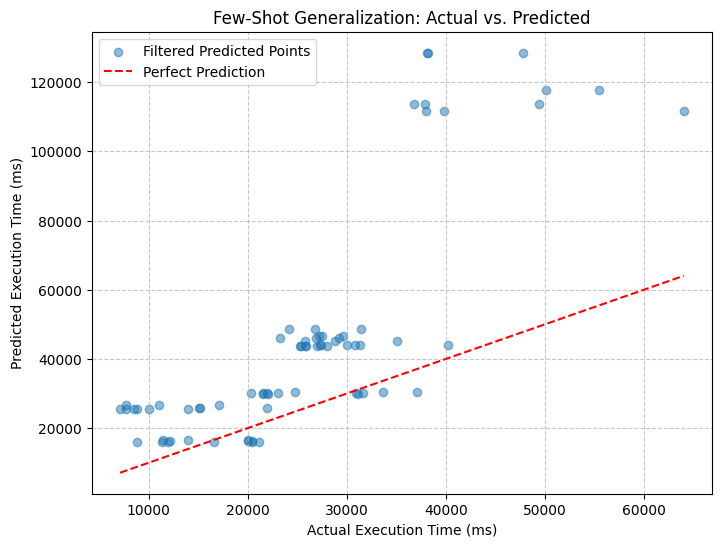

In [118]:
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()
z_scores = zscore(actuals)
threshold = 2
mask = np.abs(z_scores) < threshold

# Filter data
filtered_actuals = actuals[mask]
filtered_predictions = predictions[mask]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_actuals, filtered_predictions, alpha=0.5, label="Filtered Predicted Points")
plt.plot([min(filtered_actuals), max(filtered_actuals)], [min(filtered_actuals), max(filtered_actuals)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Execution Time (ms)")
plt.ylabel("Predicted Execution Time (ms)")
plt.title("Few-Shot Generalization: Actual vs. Predicted")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Zero-shot evaluation for RNN model to test generalization

We first identify and separate zero-shot queries. We exclude specific query IDs for 5, 15, 20 for all variations from the training set and reserve them for the test set.

In [119]:
# Filter out the data with specific query IDs
excluded_ids = ['5', '15', '10']
excluded_variations = [f"{id_}{variation}" for id_ in excluded_ids for variation in ['a', 'b', 'c', 'd', 'e']]
excluded_queries = excluded_ids + excluded_variations

train_df = df[~df['query_id'].isin(excluded_queries)]  # Exclude queries for training
test_df = df[df['query_id'].isin(excluded_queries)]
print(train_df.shape)
print(test_df.shape)

(642, 6)
(108, 6)


In [120]:
X_train = np.vstack(train_df['query_embedding'].to_numpy())
index_train = train_df['if_indexed'].values.reshape(-1, 1)
y_train = train_df['execution time (ms)'].values

X_test = np.vstack(test_df['query_embedding'].to_numpy())
index_test = test_df['if_indexed'].values.reshape(-1, 1)
y_test = test_df['execution time (ms)'].values
scaler = StandardScaler()

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

X_train_combined = np.hstack((X_train, index_train))
X_test_combined = np.hstack((X_test, index_test))

X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [121]:
# Init the RNN model, loss function, and optimizer
model = RNNPredictor(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

Epoch 1/50, Training Loss: 1.0459
Epoch 2/50, Training Loss: 0.8819
Epoch 3/50, Training Loss: 0.7952
Epoch 4/50, Training Loss: 0.9591
Epoch 5/50, Training Loss: 0.7558
Epoch 6/50, Training Loss: 0.6385
Epoch 7/50, Training Loss: 0.8235
Epoch 8/50, Training Loss: 0.7408
Epoch 9/50, Training Loss: 0.6777
Epoch 10/50, Training Loss: 0.5934
Epoch 11/50, Training Loss: 0.6855
Epoch 12/50, Training Loss: 0.6237
Epoch 13/50, Training Loss: 0.6518
Epoch 14/50, Training Loss: 0.6616
Epoch 15/50, Training Loss: 0.6525
Epoch 16/50, Training Loss: 0.6514
Epoch 17/50, Training Loss: 0.6598
Epoch 18/50, Training Loss: 0.7741
Epoch 19/50, Training Loss: 0.6923
Epoch 20/50, Training Loss: 0.6739
Epoch 21/50, Training Loss: 0.6205
Epoch 22/50, Training Loss: 0.5418
Epoch 23/50, Training Loss: 0.6056
Epoch 24/50, Training Loss: 0.6266
Epoch 25/50, Training Loss: 0.6994
Epoch 26/50, Training Loss: 0.5938
Epoch 27/50, Training Loss: 0.7747
Epoch 28/50, Training Loss: 0.5647
Epoch 29/50, Training Loss: 0

Test for zero-shot queries

In [122]:
model.eval()
test_loss = 0
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # Store predictions and actual values
        predictions.extend(scaler.inverse_transform(outputs.numpy()))
        actuals.extend(scaler.inverse_transform(y_batch.numpy()))

avg_test_loss = test_loss / len(test_loader)
print(f"Zero-Shot Test MSE Loss: {avg_test_loss:.4f}, RMSE: {np.sqrt(avg_test_loss):.4f}")
print(f"Zero-Shot Test RMSE Loss in original scale: {np.sqrt(np.mean((np.array(predictions) - np.array(actuals)) ** 2)):.4f}")

Zero-Shot Test MSE Loss: 2.6214, RMSE: 1.6191
Zero-Shot Test RMSE Loss in original scale: 98052.0156


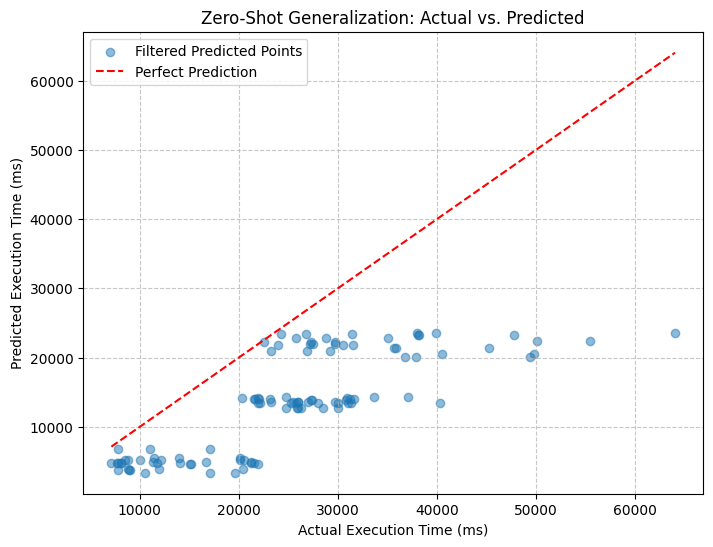

In [126]:
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()
z_scores = zscore(actuals)
threshold = 1
mask = np.abs(z_scores) < threshold

# Filter data
filtered_actuals = actuals[mask]
filtered_predictions = predictions[mask]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_actuals, filtered_predictions, alpha=0.5, label="Filtered Predicted Points")
plt.plot([min(filtered_actuals), max(filtered_actuals)], [min(filtered_actuals), max(filtered_actuals)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Execution Time (ms)")
plt.ylabel("Predicted Execution Time (ms)")
plt.title("Zero-Shot Generalization: Actual vs. Predicted")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# CNN Exploration

We explore the CNN model as an alternative, but it doesn't perform well on this dataset.

In [ ]:
class CNNPredictor(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, output_size):
        super(CNNPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear((input_size - kernel_size + 1) // 2 * num_filters, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: (batch_size, 1, input_size)
        x = self.conv1(x)   # Convolutional layer
        x = self.relu(x)    # Activation
        x = self.pool(x)    # Max-pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:

# Prepare the feature matrix (embeddings + index feature) and target
X = np.vstack(df['query_embedding'].to_numpy())
index_feature = df['if_indexed'].values.reshape(-1, 1)
y = df['execution time (ms)'].values
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Combine embeddings and index feature
X_combined = np.hstack((X, index_feature))

X_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Epoch [1/50], Training Loss: 348.2683, Test MSE Loss: 11.4554
Epoch [2/50], Training Loss: 3.8788, Test MSE Loss: 3.2409
Epoch [3/50], Training Loss: 0.5384, Test MSE Loss: 2.9367
Epoch [4/50], Training Loss: 0.4979, Test MSE Loss: 2.9002
Epoch [5/50], Training Loss: 0.4927, Test MSE Loss: 2.9011
Epoch [6/50], Training Loss: 0.4832, Test MSE Loss: 2.9171
Epoch [7/50], Training Loss: 0.5210, Test MSE Loss: 2.9073
Epoch [8/50], Training Loss: 0.5095, Test MSE Loss: 3.1642
Epoch [9/50], Training Loss: 0.5301, Test MSE Loss: 2.8936
Epoch [10/50], Training Loss: 0.5077, Test MSE Loss: 3.2246
Epoch [11/50], Training Loss: 0.5157, Test MSE Loss: 2.8912
Epoch [12/50], Training Loss: 0.4929, Test MSE Loss: 3.0090
Epoch [13/50], Training Loss: 0.6185, Test MSE Loss: 2.9405
Epoch [14/50], Training Loss: 0.5086, Test MSE Loss: 3.0036
Epoch [15/50], Training Loss: 0.5207, Test MSE Loss: 3.3416
Epoch [16/50], Training Loss: 0.5641, Test MSE Loss: 2.8938
Epoch [17/50], Training Loss: 0.4736, Test MSE

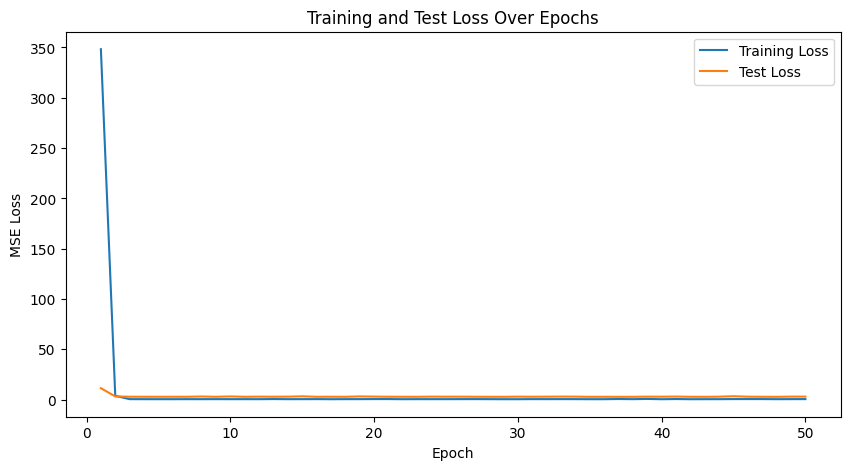

In [ ]:
# Model configuration
input_size = X_tensor.shape[1]
num_filters = 128
kernel_size = 3   # the convolutional kernel
output_size = 1

model = CNNPredictor(input_size, num_filters, kernel_size, output_size)

criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Optimizer

train_losses = []
test_losses = []

# Training loop with model checkpointing for best weights
num_epochs = 50
best_test_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation on test data (acting as validation)
    model.eval()
    test_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            y_pred_ori = scaler.inverse_transform(outputs.numpy())
            y_actual_ori = scaler.inverse_transform(y_batch.numpy())
            predictions.extend(y_pred_ori)
            actuals.extend(y_actual_ori)

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Test MSE Loss: {avg_test_loss:.4f}')
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_test_loss_ori = np.mean((np.array(predictions) - np.array(actuals)) ** 2)
        best_model_state = model.state_dict()  # Save best model weights

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with Test MSE Loss in original scale: {best_test_loss_ori:.4f}")
    print(f"Loaded best model with Test RMSE Loss in original scale: {np.sqrt(best_test_loss_ori):.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()
